<a href="https://colab.research.google.com/github/Tanay2103/Brain-Tumor-Classification-using-CNN-with-Optimized-SVM/blob/main/Multiclass_classification_BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap pyswarms deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 15.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarms.single import GlobalBestPSO

# Define paths
train_dir = '/content/drive/MyDrive/mridata2/Training'
test_dir = '/content/drive/MyDrive/mridata2/Testing'

# Label mapping
label_mapping = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'pituitary_tumor': 2,
    'no_tumor': 3
}

# Load images and labels
def load_data_from_directory(directory):
    images = []
    labels = []
    for label_dir in os.listdir(directory):
        label_path = os.path.join(directory, label_dir)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img, (128, 128))
                img_normalized = img_resized / 255.0
                images.append(img_normalized)
                labels.append(label_mapping[label_dir])
    return np.array(images), np.array(labels)

# Load data
X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Reshape images for CNN input
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)

# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Define CNN architecture
def create_best_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        Dropout(0.2),

        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(4, activation='softmax')  # 4 categories
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
best_cnn_model = create_best_cnn(input_shape=(128, 128, 1))

# Path to save the best model
checkpoint_path = "best_cnn_model.keras"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'  # Save the model with the minimum val_loss
)

# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=20,         # Random rotations up to 20 degrees
    width_shift_range=0.2,     # Horizontal shift up to 20%
    height_shift_range=0.2,    # Vertical shift up to 20%
    zoom_range=0.2,            # Random zoom within 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill missing pixels with the nearest value
)

# Fit the data augmentation generator to the training data
datagen.fit(X_train_split)

# Train the model using augmented data
history = best_cnn_model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    verbose=1
    #callbacks=[checkpoint]  # Include the checkpoint callback
)

# Load the best weights
#best_cnn_model.load_weights(checkpoint_path)

# Evaluate on the test set with the best weights
test_loss, test_accuracy = best_cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy with Best Model: {test_accuracy * 100:.2f}%")

# Extract features
def extract_features(model, data):
    feature_extractor = Sequential(model.layers[:-2])  # Remove final dense layers
    features = feature_extractor.predict(data)
    return features

# Extract features using the best CNN model
X_train_features = extract_features(best_cnn_model, X_train)
X_test_features = extract_features(best_cnn_model, X_test)

print("Feature extraction completed.")


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.4928 - loss: 1.1523 - val_accuracy: 0.2944 - val_loss: 1.5412
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.5906 - loss: 0.9595 - val_accuracy: 0.2944 - val_loss: 2.2016
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.6149 - loss: 0.8809 - val_accuracy: 0.0470 - val_loss: 1.7516
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.6906 - loss: 0.7510 - val_accuracy: 0.2770 - val_loss: 2.2094
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.7353 - loss: 0.6681 - val_accuracy: 0.2944 - val_loss: 6.9739
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.7559 - loss: 0.6162 - val_accuracy: 0.3972 - val_loss: 3.3552
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.7824 - loss: 0.5424 - val_accuracy: 0.6185 - val_loss: 1.2104
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.7697 - loss: 0.5551 - val_accuracy: 0.3589 - v

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pyswarms.single.global_best import GlobalBestPSO
import numpy as np

# Convert one-hot encoded labels to integers
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Define PSO fitness function for SVM
def pso_svm_fitness(params):
    n_particles = params.shape[0]
    fitness_values = []
    for i in range(n_particles):
        C = max(0.1, params[i, 0])  # Ensure C > 0
        gamma = max(1e-4, params[i, 1])  # Ensure gamma > 0

        svm_model = SVC(C=C, gamma=gamma, kernel='rbf')
        svm_model.fit(X_train_features, y_train_classes)

        predictions = svm_model.predict(X_train_features)
        accuracy = accuracy_score(y_train_classes, predictions)
        fitness_values.append(-accuracy)  # PSO minimizes, so negative accuracy
    return np.array(fitness_values)

# Optimized PSO bounds for SVM parameters
pso_bounds = ([1, 1e-4], [500, 10])  # Expanded range for higher flexibility
pso_options = {'c1': 1.5, 'c2': 2.0, 'w': 0.5}  # Aggressive exploration and exploitation

# Initialize PSO optimizer
pso_optimizer = GlobalBestPSO(n_particles=30, dimensions=2, options=pso_options, bounds=pso_bounds)

# Optimize SVM parameters
best_cost_pso, best_params_pso = pso_optimizer.optimize(pso_svm_fitness, iters=100)

C_pso = max(1, best_params_pso[0])
gamma_pso = max(1e-4, best_params_pso[1])

print(f"PSO Optimized Parameters: C={C_pso}, gamma={gamma_pso}")

# Train and evaluate the optimized SVM model
svm_optimized = SVC(C=C_pso, gamma=gamma_pso, kernel='rbf')
svm_optimized.fit(X_train_features, y_train_classes)

# Evaluate Performance
svm_predictions = svm_optimized.predict(X_test_features)
accuracy = accuracy_score(y_test_classes, svm_predictions)
print(f"PSO Optimized SVM Accuracy: {accuracy:.4f}")

2024-12-17 12:53:54,221 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 2.0, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1
2024-12-17 16:21:07,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0, best pos: [438.10922591   6.9624575 ]


PSO Optimized Parameters: C=438.10922590687545, gamma=6.962457496778775
PSO Optimized SVM Accuracy: 0.8477


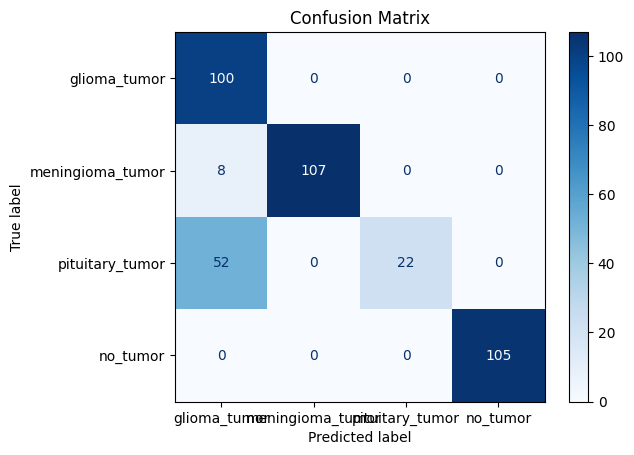

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.62      1.00      0.77       100
meningioma_tumor       1.00      0.93      0.96       115
 pituitary_tumor       1.00      0.30      0.46        74
        no_tumor       1.00      1.00      1.00       105

        accuracy                           0.85       394
       macro avg       0.91      0.81      0.80       394
    weighted avg       0.90      0.85      0.83       394



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, svm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate and print F1-score, Precision, and Recall
report = classification_report(y_test_classes, svm_predictions, target_names=list(label_mapping.keys()))
print("Classification Report:\n")
print(report)